# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

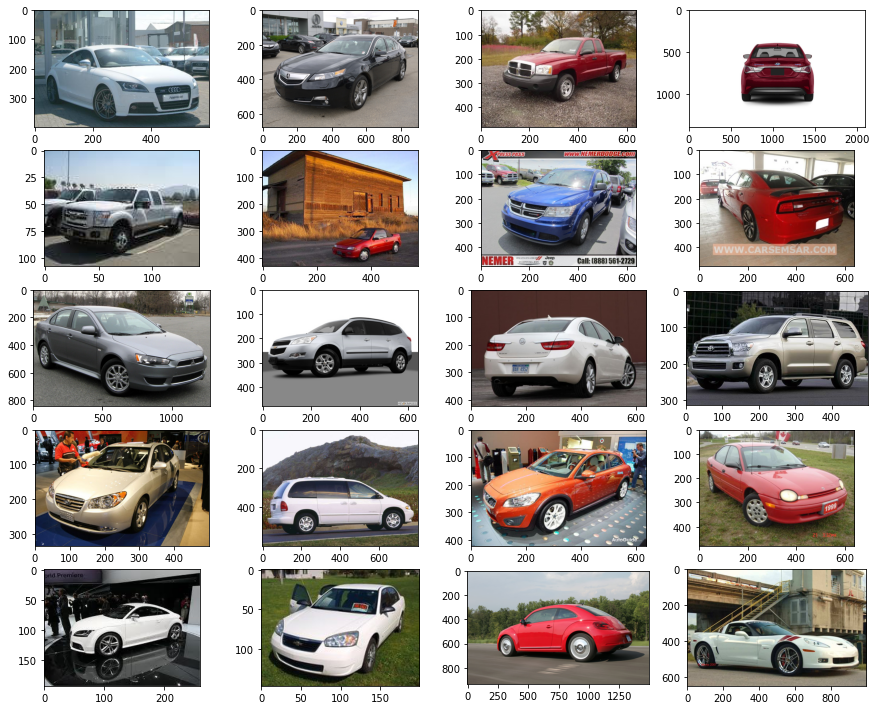

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn
from matplotlib.lines import Line2D

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(num_samples//cols + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root=".", download=True)
show_images(data)

# HyperParameters

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 16
patch_size = 64
number_of_patches = (IMG_SIZE // patch_size)**2
T = 50

Later in this notebook we will do some additional modifications to this dataset, for example make the images smaller, convert them to tensors ect. 

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [3]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class ShufflePatches(object):
  def __init__(self, patch_size):
    self.ps = patch_size

  def __call__(self, x, perm):
    # divide the batch of images into non-overlapping patches
    u = F.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    # permute the patches of each image in the batch
    # torch.randperm(b_.shape[-1])
    pu = torch.cat([b_[:, perm][None,...] for b_ in u], dim=0)
    # fold the permuted patches back together
    f = F.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    return f

def create_single_perm(number_of_patches):
    swap_idx = torch.randint(number_of_patches, (2,))
    perm = torch.arange(number_of_patches)
    perm[swap_idx] = torch.tensor([swap_idx[1], swap_idx[0]])
    return perm


def compose(a, b):
    return a[b]


def forward_shuffle(img, t, patch_size = 8, identity_prob=0.5):
    permutations = [create_single_perm(number_of_patches) for _ in range(t)]
    shuffle = ShufflePatches(patch_size)
    
    if torch.rand(1) < identity_prob*((T-t+1)/T):
        return image, torch.arange(number_of_patches), torch.arange(number_of_patches)
    
    c = torch.arange(number_of_patches)
    for p in permutations:
        c = compose(p, c)
    last = c if t==0 else permutations[-1]
    return shuffle(img, c), c, last

cuda


Let's test it on our dataset ...

In [4]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
# data = torch.utils.data.Subset(data, range(160))

train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# subset_dataset = torch.utils.data.Subset(data, range(len(data)-10, len(data)))
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
print(len(dataloader), len(testloader))

910 1619


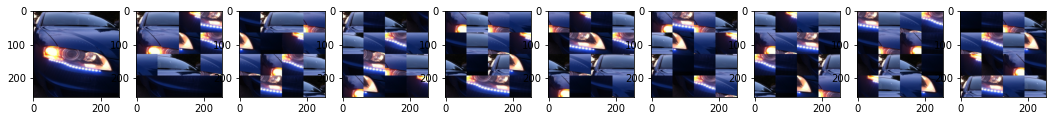

In [5]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(20,20))
plt.axis('off')
num_images = 10
stepsize = int(T//num_images)
for idx in range(0, T, stepsize):
    t = idx
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    per_img, permutation, last = forward_shuffle(image, t, patch_size, identity_prob=0)
    show_tensor_image(per_img)


In [6]:
# # Simulate forward diffusion
# image = next(iter(dataloader))[0]

# plt.figure(figsize=(15,15))
# plt.axis('off')
# num_images = 10
# stepsize = int(T/num_images)

# for idx in range(0, T, stepsize):
#     t = torch.Tensor([idx]).type(torch.int64)
#     plt.subplot(1, num_images+1, (idx/stepsize) + 1)
#     image, noise = forward_diffusion_sample(image, t)
#     show_tensor_image(image)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [7]:
# temperature = 0.1
# noise_factor = 0 #  1.0
# n_iter_sinkhorn = 10
# samples_per_num = 1 # todo check this parameter

In [8]:
class SinkhornLayer(nn.Module):
    def __init__(self, temperature, n_iterations=20):
        super().__init__()
        self.temperature = temperature
        self.n_iterations = n_iterations

    def forward(self, log_alpha):
        log_alpha = log_alpha/self.temperature
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)

        noise = torch.empty_like(log_alpha, device=device).uniform_(0, 1)
        noise = torch.log(noise)
        log_alpha = log_alpha+noise
        
        for i in range(self.n_iterations):
            # torch.logsumexp(input, dim, keepdim, out=None)
            #Returns the log of summed exponentials of each row of the input tensor in the given dimension dim
            #log_alpha -= (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            #log_alpha -= (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
            #avoid in-place
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
        return torch.exp(log_alpha)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim, kernel_size=(5,5)):
        super().__init__()
        c, h, w = input_size
        self.output_dim = output_dim
        # self.patch_conv = 
        self.conv1 = nn.Conv2d(c, hidden_dim, kernel_size)
        self.time_mlp1 = nn.Linear(32, hidden_dim)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_dim, 16, kernel_size)
        self.time_mlp2 = nn.Linear(32, 16)

        h_out = (((h-(kernel_size[0]-1)-1+1)//2)-4)//2
        self.fc1 = nn.Linear(16 * h_out * h_out, 120)
        self.fc2 = nn.Linear(120, output_dim)

    def forward(self, x, t):
        time_emb = F.relu(self.time_mlp1(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.pool(F.relu(self.conv1(x)))
        x = x + time_emb
        time_emb = F.relu(self.time_mlp2(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.pool(F.relu(self.conv2(x)))
        x = x + time_emb
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class VggEncoder(torch.nn.Module):
    def __init__(self, input_size, hidden_dim, output_dim, kernel_size=(5,5)):
        super().__init__()
        c, h, w = input_size
        self.output_dim = output_dim
        # self.patch_conv = 
        self.vgg = torchvision.models.vgg11(weights='DEFAULT')
        self.vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=output_dim, bias=True)

        self.time_mlp1 = nn.Linear(32, output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)

    def forward(self, x, t):
        time_emb = F.relu(self.time_mlp1(t))
        # Extend last 2 dimensions
        # time_emb = time_emb[(..., ) + (None, ) * 2]
        x = self.vgg(x)
        x = x + time_emb
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = self.fc2(x)
        return x


class PermNet(torch.nn.Module):
    def __init__(self, encoder, encoder_out_size, input_size, patch_size):
        super().__init__()
        self.encoder = encoder
        number_of_patches = (input_size // patch_size)**2
        self.output_size = number_of_patches
        self.patch_size = patch_size
        self.fc1 = nn.Linear(encoder_out_size, self.output_size)

        self.sinkhorn = SinkhornLayer(temperature=0.7, n_iterations=10)

        # Time embedding
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

    def forward(self, x, t):
        batch_size = x.shape[0]
        x = x.unfold(2, self.patch_size, self.patch_size)
        x = x.unfold(3, self.patch_size, self.patch_size)
        # (#n_pieces, channels, patch_size, patch_size)
        x = x.permute(0,2,3,1,4,5)
        x = x.reshape(-1,3,self.patch_size,self.patch_size)

        time_emb = self.time_mlp(t)
        x = self.encoder(x, time_emb)
        x = self.fc1(x)
        #reshape to cubic for sinkhorn operation
        x = x.reshape(batch_size, self.output_size, self.output_size)
        x = self.sinkhorn(x)
        # x, log_alpha_w_noise = my_gumbel_sinkhorn(x, temperature, samples_per_num, noise_factor,  n_iter_sinkhorn, squeeze=False)
        x = x.reshape(batch_size, self.output_size, self.output_size)

        return x

# with torch.no_grad():
#     a = torch.rand(1,3,256,256)
#     E = Encoder((3,32,32),64,64)
#     # E(a)
#     P = PermNet(E, 64, 64, 32)
#     p = P(a, t = torch.full((1,), 1, device='cpu', dtype=torch.long))
    # print(p.shape)
    # print(p)
#     plt.imshow(p.numpy().reshape(64,64))

In [9]:
# from torch import nn
# import math


# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()
        
#     def forward(self, x, t, ):
#         # First Conv
#         h = self.bnorm(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         print("A", time_emb.shape)
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         print("B", time_emb.shape)
#         # Add time channel
#         print("C", h.shape)
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return self.transform(h)


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         return embeddings


# class SimpleUnet(nn.Module):
#     """
#     A simplified variant of the Unet architecture.
#     """
#     def __init__(self):
#         super().__init__()
#         image_channels = 3
#         down_channels = (64, 128, 256, 512, 1024)
#         up_channels = (1024, 512, 256, 128, 64)
#         out_dim = 1 
#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )
        
#         # Initial projection
#         self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

#         # Downsample
#         self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
#                                     time_emb_dim) \
#                     for i in range(len(down_channels)-1)])
#         # Upsample
#         self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
#                                         time_emb_dim, up=True) \
#                     for i in range(len(up_channels)-1)])

#         self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

#     def forward(self, x, timestep):
#         # Embedd time
#         t = self.time_mlp(timestep)
#         print("AAAA", t.shape)
#         # Initial conv
#         x = self.conv0(x)
#         # Unet
#         residual_inputs = []
#         for down in self.downs:
#             x = down(x, t)
#             residual_inputs.append(x)
#         for up in self.ups:
#             residual_x = residual_inputs.pop()
#             # Add residual x as additional channels
#             x = torch.cat((x, residual_x), dim=1)           
#             x = up(x, t)
#         return self.output(x)

# model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# print(image.shape)
# s = torch.rand((2,3,32,32))
# model(s,torch.tensor([1])).shape


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [10]:
def per2mat(p):
    N = len(p)
    P = torch.zeros((N,N))
    P[torch.arange(N), p] = 1
    return P

def mat2per(P):
    N = len(P)
    p = torch.argmax(P, dim=0)
    return p

from scipy.optimize import linear_sum_assignment
def mat2perHard(P, dummy):
    row_ind, col_ind = linear_sum_assignment(P.cpu().numpy(), maximize=True)
    p = col_ind
    return p

def k_assign(assignment, n):
    """ get k-assigment, put unchanged pieces at their place
    and then put the rest of pieces"""
    diff = np.setdiff1d(np.arange(n),assignment)
    for i in diff:
        if assignment[i] >= n:
            assignment[i] = i
    diff = np.setdiff1d(np.arange(n),assignment)
    assignment[assignment>=n]= diff
    return assignment

def k_mat2perHard(P, k):
    P_numpy = P.cpu().numpy()
    m, n = P_numpy.shape
    N = m - k 
    
    new_cost_P = np.concatenate([P_numpy, 2*np.ones((m,N))], axis=1)
    row_ind, col_ind = linear_sum_assignment(new_cost_P, maximize=True)
    p = col_ind
    p = k_assign(p, len(p))
    return p


In [11]:
# def get_loss(model, x_0, t):
#     x_noisy, noise = forward_diffusion_sample(x_0, t, device)
#     noise_pred = model(x_noisy, t)
#     return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation 
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [12]:
E = Encoder((3,patch_size,patch_size),64,64)
vgg = VggEncoder((3,patch_size,patch_size),64,64)
model = PermNet(vgg, 64, 256, patch_size)
model = model.to(device)

# model.encoder.conv1.register_forward_hook(lambda x,y,z: print('grad accumulated in conv1'))
# model.time_mlp[1].weight.register_hook(lambda x: print('grad accumulated in time_mlp'))
# model.fc1.weight.register_hook(lambda x: print('grad accumulated in fc1'))


In [13]:
@torch.no_grad()
def sample_timestep(model, x, t, patch_size):
    P = model(x, t)
    P = P.squeeze()
    P = P.permute(1,0)
    k = min(1+t.item()//2, P.shape[0])
    p = k_mat2perHard(P, k)
    x_t_minus = ShufflePatches(patch_size)(x, p)
    return x_t_minus

@torch.no_grad()
def sample_plot_image(model, patch_size):
    img_size = IMG_SIZE
    img = next(iter(testloader))[0].to(device=device)
    # shuffle 
    img, p_true, p_last = forward_shuffle(img, T, patch_size=patch_size)
    # num_images = T
    stepsize = int(T/num_images)
    
    fig = plt.figure(figsize=(20,20))
    plt.axis('off')
    # plt.subplot(1, num_images+1, num_images+1)
    ax = fig.add_subplot(1, num_images+1, num_images+1)
    ax.set_title("input shuffled")

    show_tensor_image(img.detach().cpu())
    
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t, patch_size)
        
        if i % stepsize == 0:
            plt.subplot(1, num_images+1, i//stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()       

## Training

In [14]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if p.grad is None:
            ave_grads.append(0)
            max_grads.append(0)
        elif (p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [15]:
# permutation = permutations[1]
# print(permutation)
# per2mat(permutation).permute(1,0)

In [16]:
# import seaborn as sns
# sns.set()

# def plot_heatmap(tensor):
#     return sns.heatmap(tensor, annot=True, fmt=".2f")

@torch.no_grad()
def heat(arr):
    fig = plt.figure(figsize=(8,8))
    arr = arr.cpu().numpy()
    heatmap = plt.pcolor(arr)
    plt.gca().invert_yaxis()

    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % arr[y, x],
                    horizontalalignment='center',
                    verticalalignment='center',
                    )

    plt.colorbar(heatmap)

    plt.show()

In [17]:
# s = SinkhornLayer(0.0001, 100)
# o = s(torch.rand(16,16))
# o = o.reshape(16,16)
# heat(o.numpy())
# p = mat2per(o)
# print(p)
# print()
# print(np.setdiff1d(np.arange(16), p))

Epoch 0 | step 0 Loss: 6.174808025360107 


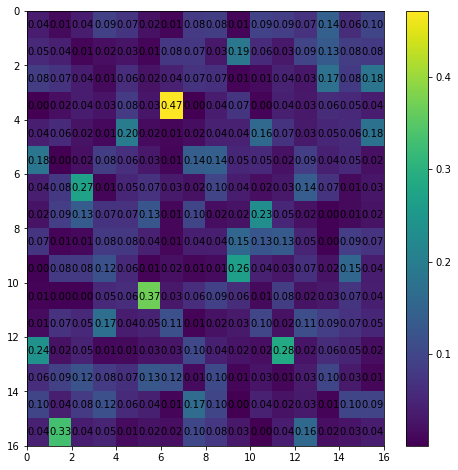

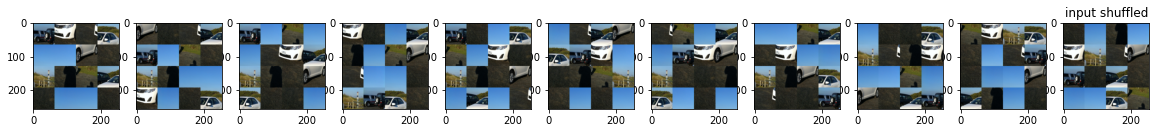

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-6)
epochs = 200 # Try more!

criterion = torch.nn.MSELoss()
model.train()
for epoch in range(epochs):
    for step, (image, label) in enumerate(dataloader):
        optimizer.zero_grad()

        # Todo - shuffle batch differently
        # t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        t = torch.randint(0, T, (1,), device=device).long()
        per_img, permutation, last_perm = forward_shuffle(image, t.item(), patch_size)
        permutation_prediction = model(per_img.to(device), t)
        ground_truth = per2mat(permutation).permute(1,0).to(device)
        ground_truth = ground_truth.expand(BATCH_SIZE, number_of_patches, number_of_patches)
        loss = criterion(permutation_prediction, 10*ground_truth)
        # loss = criterion(image, permutation_prediction)

        loss.backward()

        # plot_grad_flow(model.named_parameters())
        
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step} Loss: {loss.item()} ")
            # a = ppprint(np.round(permutation_prediction.cpu().detach().numpy(),2))
            # ax = plot_heatmap(np.round(permutation_prediction.cpu().detach().numpy()))
            # ax.plot()
            if epoch % 20 == 0:
                heat(permutation_prediction[0])
            # ax.fig.clf()
            # print("a, ", t, mat2per(permutation_prediction))
            # print(torch.histc(permutation_prediction.cpu(), bins=15, min=0, max=1.01))

            sample_plot_image(model, patch_size)